In [211]:
import wave, numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

# readfile
def audio_prep(file_name,txt_name,plot=1,listen=1,noise=0):
    fs,x_wave = wavfile.read(file_name)
    interval = np.genfromtxt(txt_name, delimiter='\t')
    

    
    x = x_wave.astype(float)
    if(noise>0):
        x += np.random.normal(0, x.max()*noise,x.shape)
        
    x_play = x.astype(int)    
    # spectrogram
    if(x.shape==(x.shape[0],)):
        f, t, Sxx = signal.spectrogram(x, fs,window=("hann"))
    else:
        f, t, Sxx = signal.spectrogram(x[:,0], fs,window=("hann"))
    if(plot == 1):
        plt.pcolormesh(t, f, np.log(Sxx+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        print("Sxx.max = ",Sxx.max())

    #Sxx /= Sxx.max()
    #Sxx = -np.log(Sxx+1e-9)
    Sxx /= Sxx.max()
    labels = np.zeros(Sxx.shape[1])
    print("Sxx.shape=",Sxx.shape)
    
            
    print("interval.shape=",interval.shape)       
    if(interval.shape == (2,)):     
        if(listen==1):
            sd.play(x_play,fs,blocking=True)
        bb,ee = int(interval[0]*fs),min(int(interval[1]*fs),(x.shape[0]))
        print("interval=",interval)
        if(plot == 1):
            
            print("fs=",fs)
            print(x.shape)
            plt.plot(np.linspace(start=0,stop=(x_play.shape[0]/fs),num=x_play.shape[0]),\
                    np.linspace(start=0,stop=0,num=x_play.shape[0]))
            plt.plot(np.linspace(start=interval[0],stop=interval[1],num=int((interval[1]-interval[0])*fs)),\
                   x_play[bb:ee,0])
            plt.plot(np.linspace(start=0,stop=interval[0],num=int((interval[0])*fs)),\
                   x_play[0:bb,0])
            if(ee<x.shape[0]):
                plt.plot(np.linspace(start=interval[1],stop=x.shape[0]/fs,num=int((x.shape[0]-ee-1))),\
                   x_play[ee+1:,0])
            #plt.plot(np.linspace(start=0,stop=x.shape[0]/fs,num=int(x.shape[0])),x[:,0])
            plt.show()

        #Sxx  = 1-Sxx
        t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
        t_ee= int(t.shape[0]*ee/x_play.shape[0])
        print("t_begin=",t_bb,"t_end=",t_ee)

        # laybel_gen - 0 is everything else, 1 is scream class            
        for i in range(t_bb,t_ee):
            labels[i] = 1

        for i in range(0,len(labels)):
            labels[i] = int(labels[i])
        Sxx = np.hstack((Sxx,0.7*Sxx[:,int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],0.8*Sxx[:,0:t_bb+int((t_ee-t_bb)/2)]))
        labels = np.hstack((labels,labels[int(t_bb/3):t_bb+int((t_ee-t_bb)/2)],labels[0:t_bb+int((t_ee-t_bb)/2)]))
        if(plot == 1):
            plt.plot(labels)
            plt.show()
            plt.plot(Sxx.T[t_bb-1])
            plt.show()
        return Sxx.T,labels
    
    else:
        Sxx_prev = Sxx[:,0:2]
        labels_prev = np.zeros(Sxx_prev.shape[1])
        print("interval=",interval)
        print("fs=",fs)
        print(x.shape)
        for j in range(0,interval.shape[0]):
            bb,ee = int(interval[j][0]*fs),int(interval[j][1]*fs)  
            
            
                

            # get the frame number of the starting and ending frames
            t_bb= int(t.shape[0]*bb/x_play.shape[0])+1
            t_ee= int(t.shape[0]*ee/x_play.shape[0])
            #print(Sxx_prev.shape, Sxx[:,max(int(t_bb/3),int(t_bb-30)):min(Sxx.shape[1],t_ee+30)].shape)
            Sxx_prev = np.hstack((Sxx_prev, Sxx[:,max(int(t_bb/3),int(t_bb-30)):min(Sxx.shape[1],t_ee+30)]))
            # laybel_gen - 0 is everything else, 1 is scream class            
            for i in range(t_bb,t_ee):
                labels[i] = 1
            for i in range(0,len(labels)):
                labels[i] = int(labels[i])
            
            labels_prev   = np.hstack((labels_prev,labels[max(int(t_bb/3),int(t_bb-100)):min(Sxx.shape[1],t_ee+100)]))
            print("t_begin=",t_bb,"t_end=",t_ee)
        t_tmp = np.linspace(start=0,stop=Sxx_prev.shape[1]*x_play.shape[0]/t.shape[0]/fs,num =Sxx_prev.shape[1])
        plt.pcolormesh(t_tmp, f, np.log(Sxx_prev+1e-8))
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        
        return Sxx_prev.T,labels_prev

In [212]:
def test_inference(file_name,txt_name,R_Net,listen=0,noise=0):
    Sxx_in, labels = audio_prep(file_name,txt_name,plot=0,listen=listen,noise=noise)
        
    result = [];
    compare = [];
    ps = int((n**2)%Sxx_in.shape[0])
    ps = np.clip(ps,0,Sxx_in.shape[0]-2*lenRec-1)
    ps = 0 
    for i in range(0,Sxx_in.shape[0]):
        infer_in_enc = Sxx_in[ps+i]

        ret = R_Net.get_prob(infer_in_enc)
        result.append(ret)
        compare.append(labels[ps+i])

    plt.plot(result)
    plt.plot(compare)
    plt.show()
    print("error variance =",np.var(np.array(result)-np.array(compare)))

In [216]:
#from LSTMbiDir import *
#from RNNbiDir import *
from LSTMSingle import *
#from RNNSingle import *

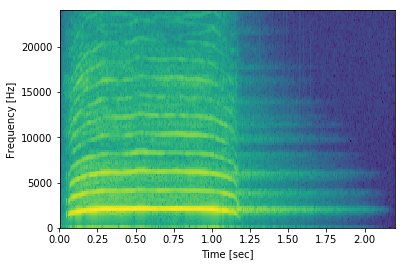

Sxx.max =  4377315345387014.0
Sxx.shape= (129, 471)
interval.shape= (2,)
interval= [0.1  1.15]
fs= 48000
(105600, 2)


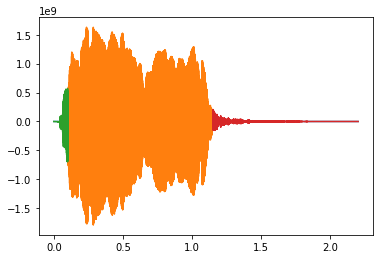

t_begin= 22 t_end= 246


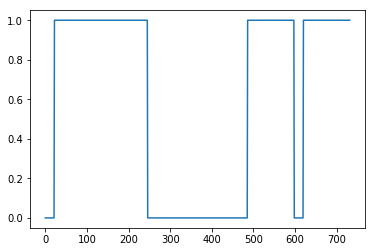

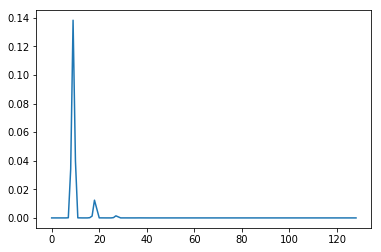

lenIn= 129  lenOut= 2  lenRec= 100


In [217]:
epoch = 30*1000;
Sxx_in,labels = audio_prep("./audio_set/data/file_00001.wav","./audio_set/text/file_00.txt",plot=1,listen=1,noise=0)

lenIn, lenOut, lenRec = Sxx_in.shape[1],2, min(150,max(min(100,Sxx_in.shape[0]),int(Sxx_in.shape[0]/10)))
sizeHidden, numHiddenLayer = 100,1;
learningRate = 0.1;

print("lenIn=",lenIn, " lenOut=",lenOut," lenRec=",lenRec)

['file_00.txt', 'file_11.txt', 'file_12.txt', 'file_17.txt', 'file_23.txt']
['file_00001.wav', 'file_11001.wav', 'file_12001.wav', 'file_17001.wav', 'file_23001.wav']
times: 1 n= 0 err: -0.693147178559946


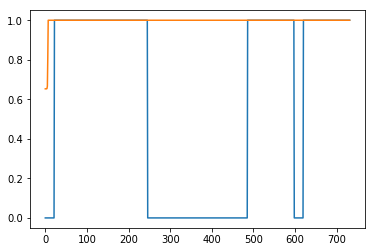

times: 17 n= 113 err: -0.022765176797901594


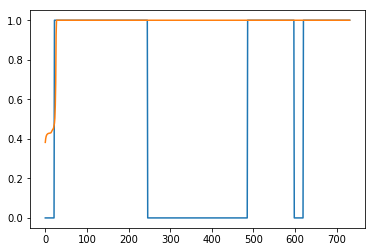

times: 33 n= 226 err: -2.9937959703910026


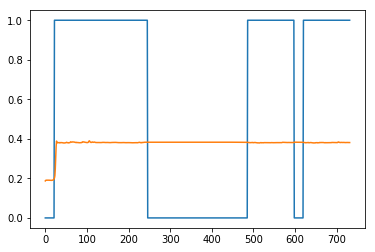

times: 49 n= 339 err: -0.01671530549548246


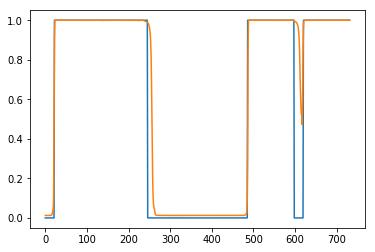

Sxx.shape= (129, 471)
interval.shape= (2,)
interval= [0.1  1.15]
t_begin= 22 t_end= 246
k updates! k =  0 New Sxx has length  732
./audio_set/data/file_00001.wav
times: 1 n= 0 err: -0.019365322021945252


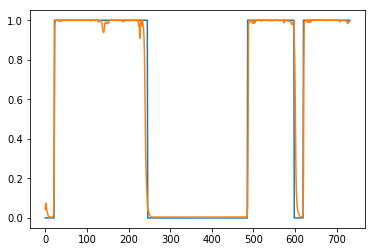

times: 17 n= 113 err: -0.005323207271801177


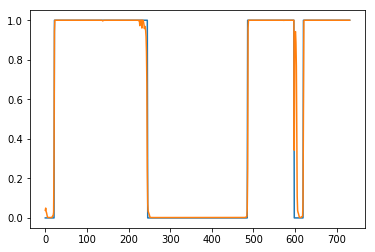

times: 33 n= 226 err: -0.09494622644931847


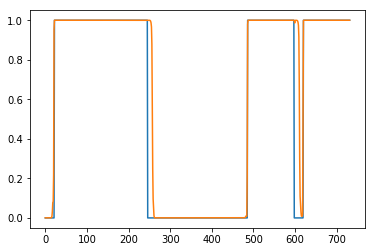

times: 49 n= 339 err: -1.0948386881276724e-05


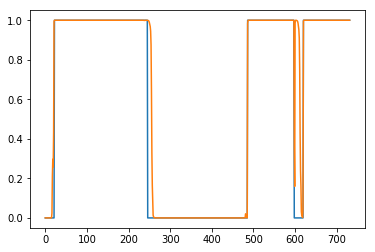

Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955
k updates! k =  1 New Sxx has length  2007
./audio_set/data/file_11001.wav
times: 1 n= 0 err: -0.0006228264683173474


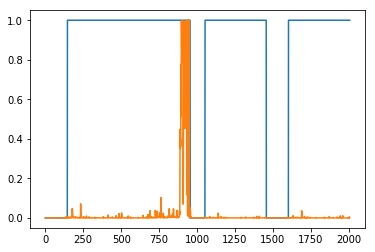

times: 6 n= 113 err: -0.006470147485580831


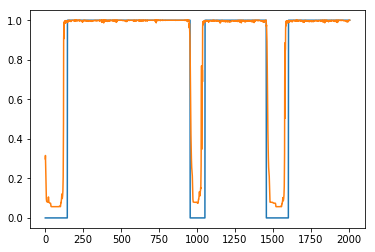

times: 12 n= 226 err: -0.00011675306025336122


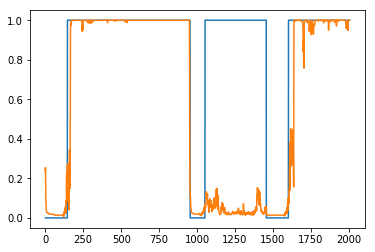

times: 17 n= 339 err: -0.0010665663076691498


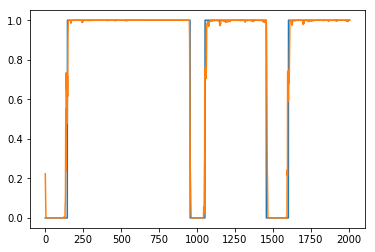

times: 23 n= 452 err: -0.00022411844456705253


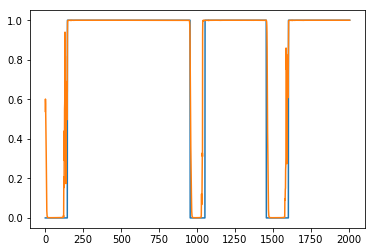

times: 29 n= 565 err: -0.00038399546899502797


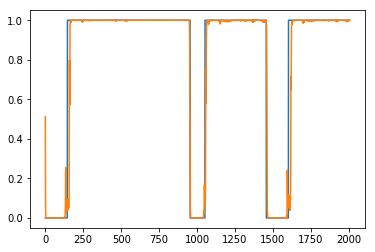

times: 34 n= 678 err: -2.4171510738450192e-05


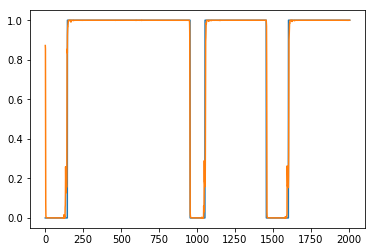

times: 40 n= 791 err: -0.00822725958368668


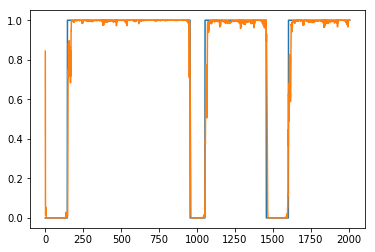

times: 46 n= 904 err: -0.00022286943933792265


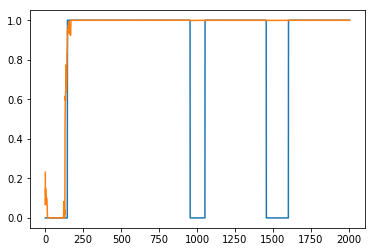

times: 51 n= 1017 err: -0.031507492182519144


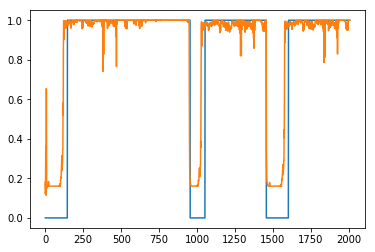

Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.163 5.   ]
t_begin= 33 t_end= 955
k updates! k =  2 New Sxx has length  1932
./audio_set/data/file_12001.wav
times: 1 n= 0 err: -0.15259807813872503


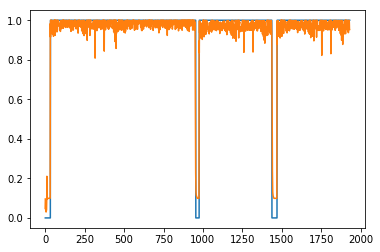

times: 6 n= 113 err: -0.0016064960710716586


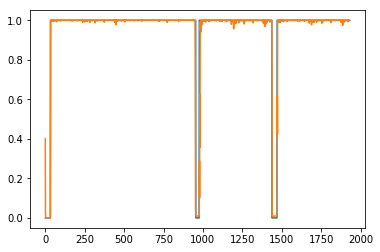

times: 12 n= 226 err: -0.0019382950714262517


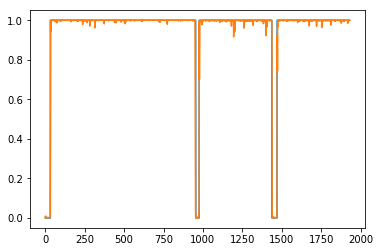

times: 18 n= 339 err: -0.0009313077676754008


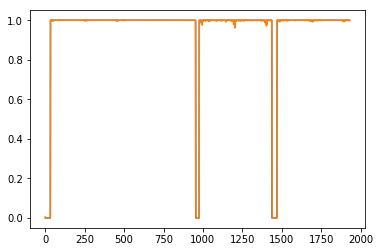

times: 24 n= 452 err: -0.011146370623027374


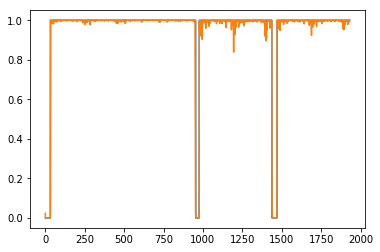

times: 30 n= 565 err: -0.05969783845879276


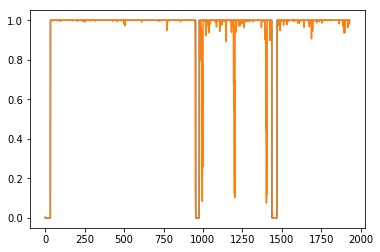

times: 36 n= 678 err: -7.613409442105356e-06


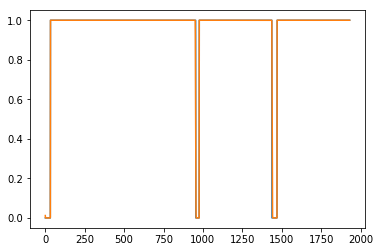

times: 42 n= 791 err: -8.839261363076877e-06


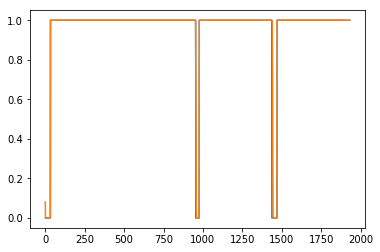

times: 48 n= 904 err: -1.0329396508664432e-05


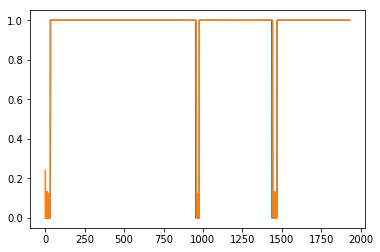

Sxx.shape= (129, 15762)
interval.shape= (4, 2)
interval= [[60.    60.585]
 [62.952 64.351]
 [67.364 68.871]
 [72.745 74.789]]
fs= 44100
(3530752,)
t_begin= 11813 t_end= 11927
t_begin= 12394 t_end= 12668
t_begin= 13263 t_end= 13558
t_begin= 14322 t_end= 14723


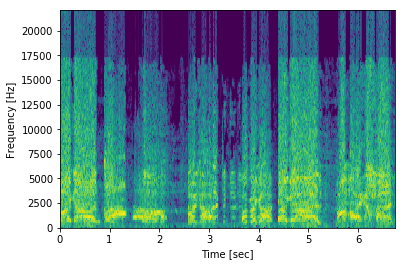

k updates! k =  3 New Sxx has length  1326
./audio_set/data/file_17001.wav
times: 1 n= 0 err: -14.013369269307919


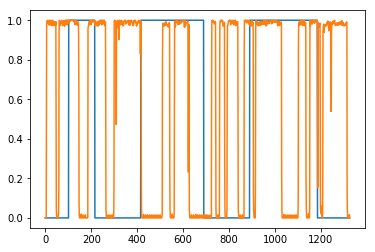

times: 9 n= 113 err: -1.4653471159693539


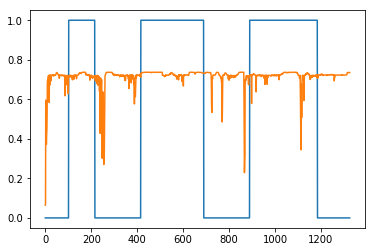

times: 18 n= 226 err: -1.1110212386194795


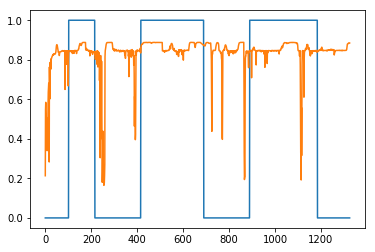

times: 27 n= 339 err: -1.4909846666805044


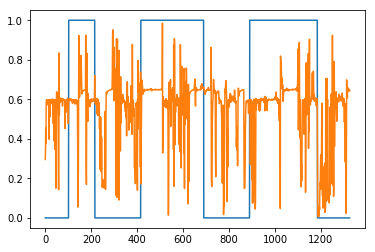

times: 35 n= 452 err: -0.2893477558925679


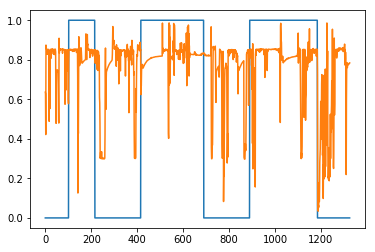

times: 44 n= 565 err: -0.3271742742052111


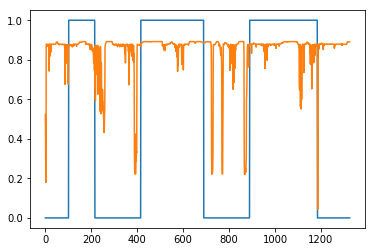

Sxx.shape= (129, 9764)
interval.shape= (2, 2)
interval= [[20.932 21.799]
 [34.932 35.665]]
fs= 44100
(2187264,)
t_begin= 4121 t_end= 4291
t_begin= 6877 t_end= 7021


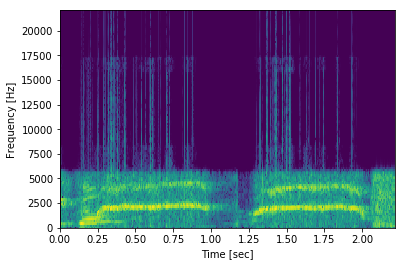

k updates! k =  4 New Sxx has length  436
./audio_set/data/file_23001.wav
times: 1 n= 0 err: -0.4725623533910104


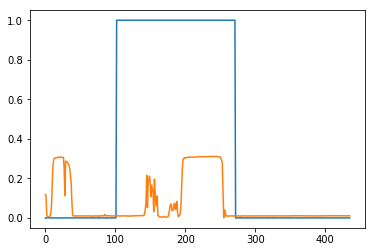

times: 29 n= 113 err: -0.0010157934087747541


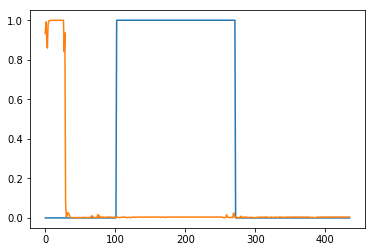

Sxx.shape= (129, 471)
interval.shape= (2,)
interval= [0.1  1.15]
t_begin= 22 t_end= 246
k updates! k =  0 New Sxx has length  732
./audio_set/data/file_00001.wav
times: 1 n= 0 err: -1.4678396038823842


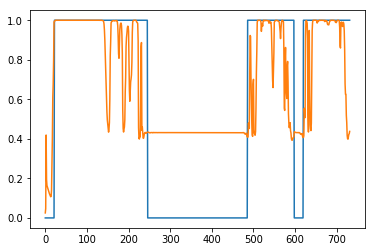

times: 17 n= 113 err: -0.004051543495772055


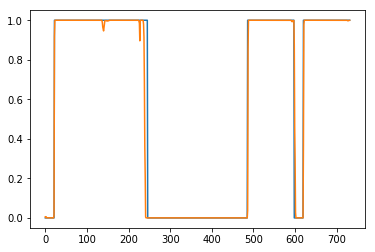

times: 33 n= 226 err: -0.15990000849199426


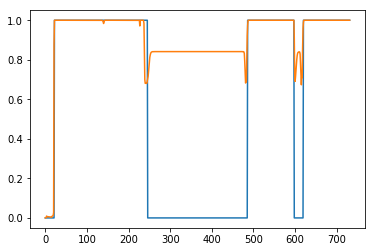

times: 49 n= 339 err: -9.967146554258053e-05


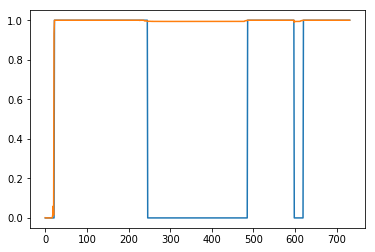

Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955
k updates! k =  1 New Sxx has length  2007
./audio_set/data/file_11001.wav
times: 1 n= 0 err: -0.011312551153561936


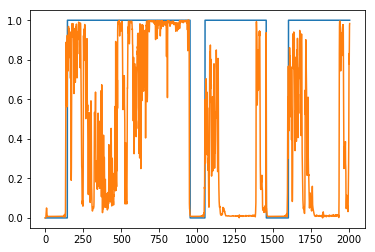

times: 6 n= 113 err: -3.040047061461334e-05


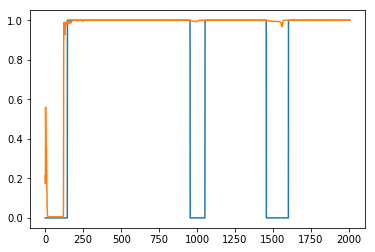

times: 12 n= 226 err: -0.00049838664247189


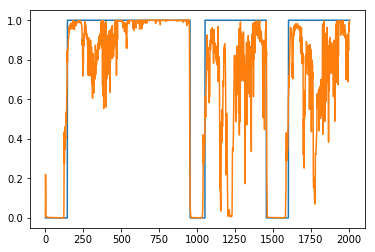

times: 17 n= 339 err: -9.662711599589108e-05


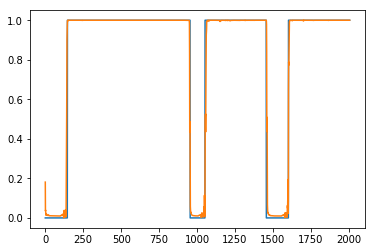

times: 23 n= 452 err: -0.0005845709504227198


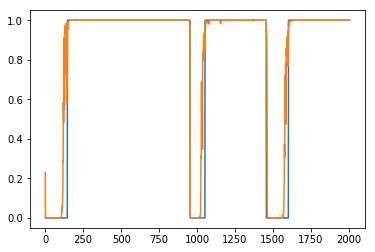

times: 29 n= 565 err: -0.0002678739698731018


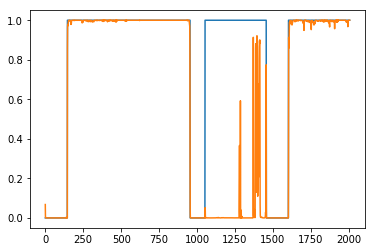

times: 34 n= 678 err: -0.0003992178396032974


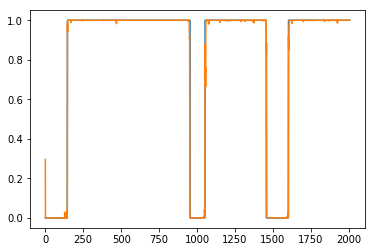

times: 40 n= 791 err: -3.7078011904240146e-05


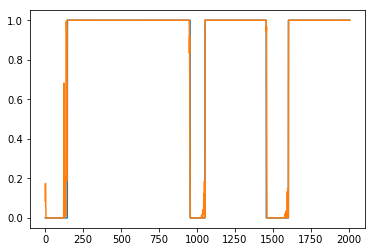

times: 46 n= 904 err: -0.0012214205562807643


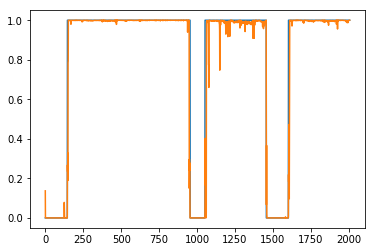

times: 51 n= 1017 err: -0.005450065546822138


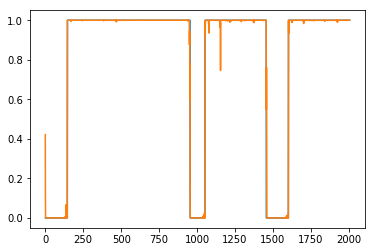

Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.163 5.   ]
t_begin= 33 t_end= 955
k updates! k =  2 New Sxx has length  1932
./audio_set/data/file_12001.wav
times: 1 n= 0 err: -2.0212056004876278


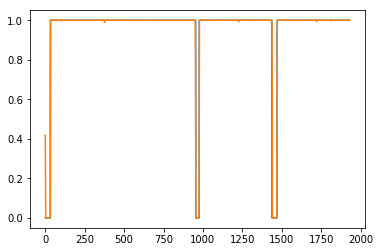

times: 6 n= 113 err: -0.0003252187783287015


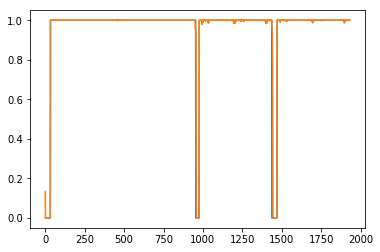

KeyboardInterrupt: 

In [218]:
# training
from os import listdir
from os.path import isfile, join
txtpath = "./audio_set/text/"
datpath = "./audio_set/data/"
txtfiles = [f for f in listdir(txtpath) if isfile(join(txtpath, f))]
print(txtfiles)
datfiles = [f for f in listdir(datpath) if isfile(join(datpath, f))]
print(datfiles)

# single LSTM
R = myRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 0;lstm=1 

# bidir LSTM
#R = lstmRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm=1 

# single RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 0;lstm = 0 

# bidir RNN
#R = basicRNN(lenIn, lenOut, lenRec, sizeHidden, Sxx_in, labels, learningRate); biDir = 1;lstm = 0 

n,k,position,time = 0,0,0,0;
while n<epoch:
    
    if(position+lenRec+1 >= Sxx_in.shape[0] or n == 0):
        if(time > 50):
            if(k == len(txtfiles)):
                k = 0;
            n = 0
            Sxx_in,labels = audio_prep("./audio_set/data/"+datfiles[k],"./audio_set/text/"+txtfiles[k],plot=0,listen=0,noise=0)
            print("k updates! k = ",k,"New Sxx has length ",Sxx_in.shape[0])
            print("./audio_set/data/"+datfiles[k])
            k = k+1
            time = 0
        if(biDir == 0):
            R.h = np.zeros_like(R.h)
            if(lstm != 0):
                R.c = np.zeros_like(R.c)
        else:
            R.hls_infer = np.zeros_like(R.hls_infer)
            R.hrs_infer = np.zeros_like(R.hrs_infer)
            if(lstm != 0):
                R.cls_infer = np.zeros_like(R.cls_infer)
                R.crs_infer = np.zeros_like(R.crs_infer)
        position = 0;
        time += 1;
        
    inputs  = Sxx_in[position:position+lenRec]
    targets  = labels[position:position+lenRec]

    R.update_inputs_targets(inputs,targets)
    R.fwd_pass();
    
    err = R.bwd_pass();
    
    if(n%113 == 0 ): # 113 is a prime number
        print("times:",time,"n=",n,"err:",err)
        
        result = []
        compare = []
        ps = 0 
        if(biDir == 0):
            # single layer
            for i in range(0,Sxx_in.shape[0]):
                infer_in_enc = Sxx_in[ps+i]

                ret = R.get_prob(infer_in_enc)
                result.append(ret)
                compare.append(labels[ps+i])
        else:
            # bi-directional
            while(ps+lenRec<Sxx_in.shape[0]):
                infer_in_enc  = Sxx_in[ps:ps+lenRec,:];
                ret = R.inference(infer_in_enc)     
                result.append(ret[:,1])
                compare.append(list(labels[ps:ps+lenRec])[:])
                ps += lenRec
            compare = np.array(compare)
            compare = np.reshape(compare,(compare.shape[0]*compare.shape[1],1))
            result = np.array(result)
            result = np.reshape(result,(result.shape[0]*result.shape[1],1))
        plt.plot(compare)
        plt.plot(result)
        
        plt.show()
    position += lenRec;
    n += 1;



Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


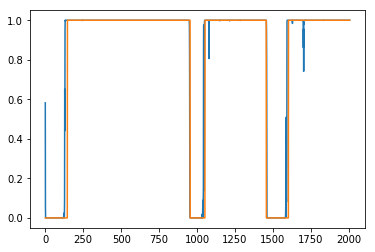

error variance = 0.018982745875570004
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


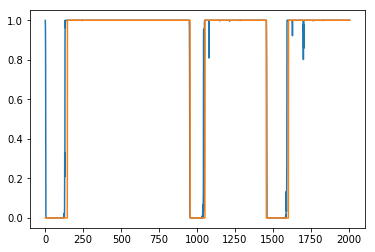

error variance = 0.019535752007480433
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


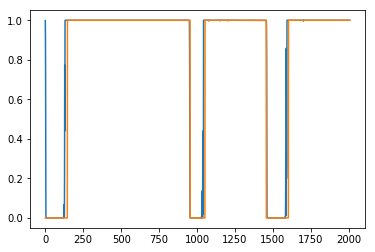

error variance = 0.02250883441713836
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


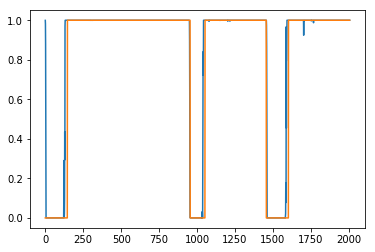

error variance = 0.02420954151836045
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


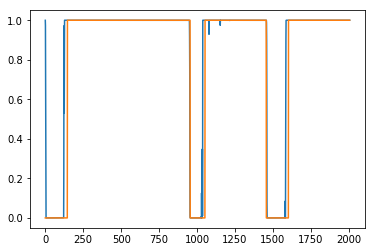

error variance = 0.0298919327395192


In [225]:
for i in range(0,5):
    test_inference("./audio_set/data/file_11001.wav","./audio_set/text/file_11.txt",R,listen=0,noise=i/20)


['file_00.txt', 'file_11.txt', 'file_12.txt', 'file_14.txt', 'file_17.txt', 'file_23.txt', 'file_24.txt', 'file_25.txt']
['file_00001.wav', 'file_11001.wav', 'file_12001.wav', 'file_14001.wav', 'file_17001.wav', 'file_23001.wav', 'file_24001.wav', 'file_25001.wav']
./audio_set/data/file_00001.wav
Sxx.shape= (129, 471)
interval.shape= (2,)
interval= [0.1  1.15]
t_begin= 22 t_end= 246


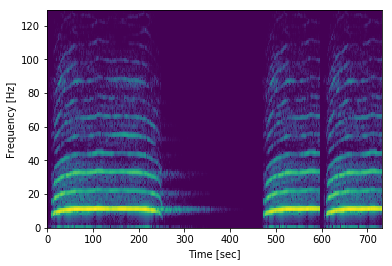

./audio_set/data/file_11001.wav
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.737 4.853]
t_begin= 146 t_end= 955


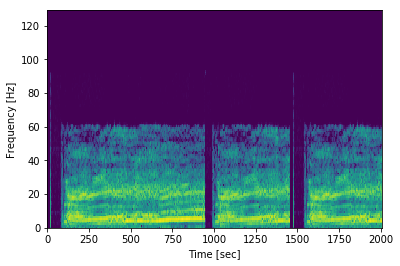

./audio_set/data/file_12001.wav
Sxx.shape= (129, 955)
interval.shape= (2,)
interval= [0.163 5.   ]
t_begin= 33 t_end= 955


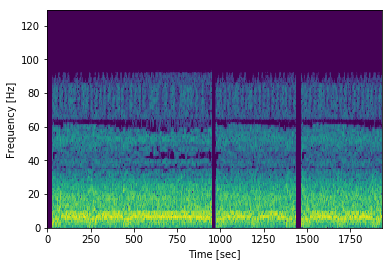

./audio_set/data/file_14001.wav
Sxx.shape= (129, 4356)
interval.shape= (3, 2)
interval= [[ 1.636  2.677]
 [13.444 17.37 ]
 [18.47  22.01 ]]
fs= 44100
(975872, 2)
t_begin= 323 t_end= 526
t_begin= 2647 t_end= 3419
t_begin= 3636 t_end= 4332


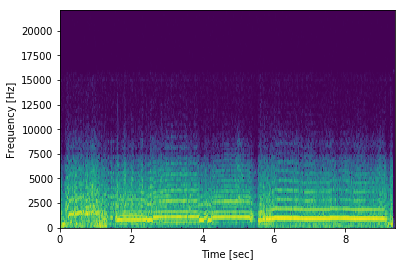

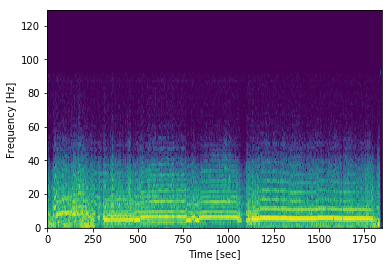

./audio_set/data/file_17001.wav
Sxx.shape= (129, 15762)
interval.shape= (4, 2)
interval= [[60.    60.585]
 [62.952 64.351]
 [67.364 68.871]
 [72.745 74.789]]
fs= 44100
(3530752,)
t_begin= 11813 t_end= 11927
t_begin= 12394 t_end= 12668
t_begin= 13263 t_end= 13558
t_begin= 14322 t_end= 14723


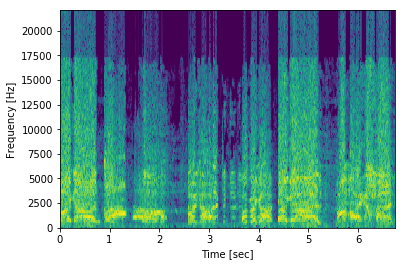

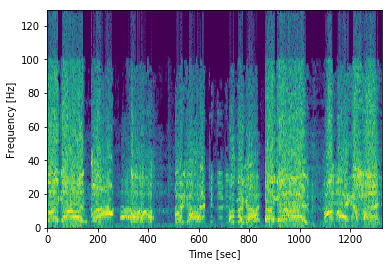

./audio_set/data/file_23001.wav
Sxx.shape= (129, 9764)
interval.shape= (2, 2)
interval= [[20.932 21.799]
 [34.932 35.665]]
fs= 44100
(2187264,)
t_begin= 4121 t_end= 4291
t_begin= 6877 t_end= 7021


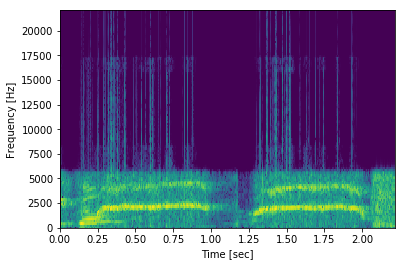

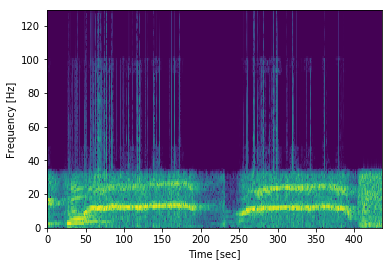

./audio_set/data/file_24001.wav
Sxx.shape= (129, 8690)
interval.shape= (8, 2)
interval= [[ 3.619  3.975]
 [ 5.874  6.348]
 [12.637 14.052]
 [15.01  15.839]
 [19.875 20.469]
 [21.477 21.952]
 [23.969 25.393]
 [27.588 28.004]]
fs= 44100
(1946624, 2)
t_begin= 713 t_end= 782
t_begin= 1157 t_end= 1249
t_begin= 2488 t_end= 2766
t_begin= 2955 t_end= 3118
t_begin= 3913 t_end= 4029
t_begin= 4229 t_end= 4321
t_begin= 4719 t_end= 4999
t_begin= 5432 t_end= 5513


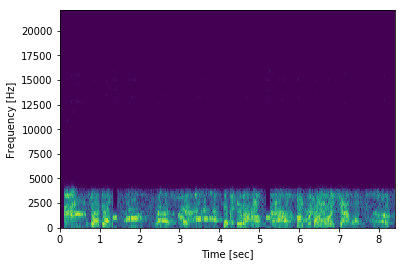

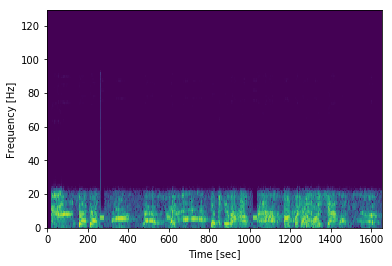

./audio_set/data/file_25001.wav
Sxx.shape= (129, 7949)
interval.shape= (7, 2)
interval= [[20.176 22.469]
 [23.066 27.3  ]
 [27.842 29.199]
 [30.068 31.099]
 [31.641 34.192]
 [35.006 36.038]
 [36.472 39.565]]
fs= 44100
(1780736, 2)
t_begin= 3972 t_end= 4423
t_begin= 4541 t_end= 5374
t_begin= 5481 t_end= 5748
t_begin= 5920 t_end= 6122
t_begin= 6229 t_end= 6730
t_begin= 6892 t_end= 7094
t_begin= 7180 t_end= 7788


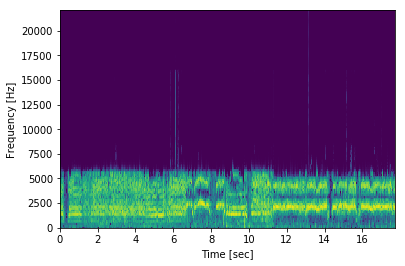

KeyboardInterrupt: 

In [206]:
from os import listdir
from os.path import isfile, join
txtpath = "./audio_set/text/"
datpath = "./audio_set/data/"
txtfiles = [f for f in listdir(txtpath) if isfile(join(txtpath, f))]
print(txtfiles)
datfiles = [f for f in listdir(datpath) if isfile(join(datpath, f))]
print(datfiles)
for k in range(len(txtfiles)):
    print("./audio_set/data/"+datfiles[k])
    Sxx,lb = audio_prep("./audio_set/data/"+datfiles[k],"./audio_set/text/"+txtfiles[k],plot=0,listen=0,noise=0)
    plt.pcolormesh(np.log(Sxx.T+1e-8))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()